# Parameter estimation

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import tqdm

import warnings
warnings.filterwarnings('ignore')


## Import datasets

In [2]:
#bulk fluorescence data
fluo = pd.read_csv('datasets/bulk-fluo-11.csv', index_col=0)
num_traces = fluo.shape[1]
fluo.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,e16TerThyXS1,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
time,,,,,,,,,,,,,,,,,,,,,
0,21.62500,14.10682,-10.20240,-14.73152,33.51864,54.76527,30.03510,30.74070,76.93035,98.94185,101.80665,62.13312,17.90467,-6.91299,24.62000,76.44860,19.578000,-10.77699,24.425500,12.62616,31.97744
20,-101.37366,64.33200,63.38460,87.34615,175.67310,99.96154,89.73077,173.29753,127.39316,161.16140,140.73080,-129.68964,-137.81250,-85.89522,62.82879,126.96154,92.153847,109.12588,107.615385,156.70011,160.07416
40,-52.95490,-38.89568,-37.80715,-46.18264,-12.37340,-2.86740,-48.26601,-15.48820,-18.92473,20.74640,25.18580,-42.28900,-63.66528,-55.83582,-41.68976,-12.08031,-17.210700,-12.37340,-42.180800,13.03740,58.06452
60,-98.18847,-10.39050,23.09808,-15.46116,52.78819,24.15460,31.13992,42.37074,37.52530,56.37600,39.48879,-87.81814,-119.76525,-93.24080,-7.20240,47.33113,-13.380450,5.12220,27.694420,7.57491,61.09570
80,-53.51717,13.43900,6.63873,4.95120,42.97700,18.45877,25.04068,60.71615,64.04811,27.90936,56.60975,-61.15626,-95.25761,-49.29870,-0.86548,22.69449,7.170800,8.86480,-0.989730,33.28956,44.47770


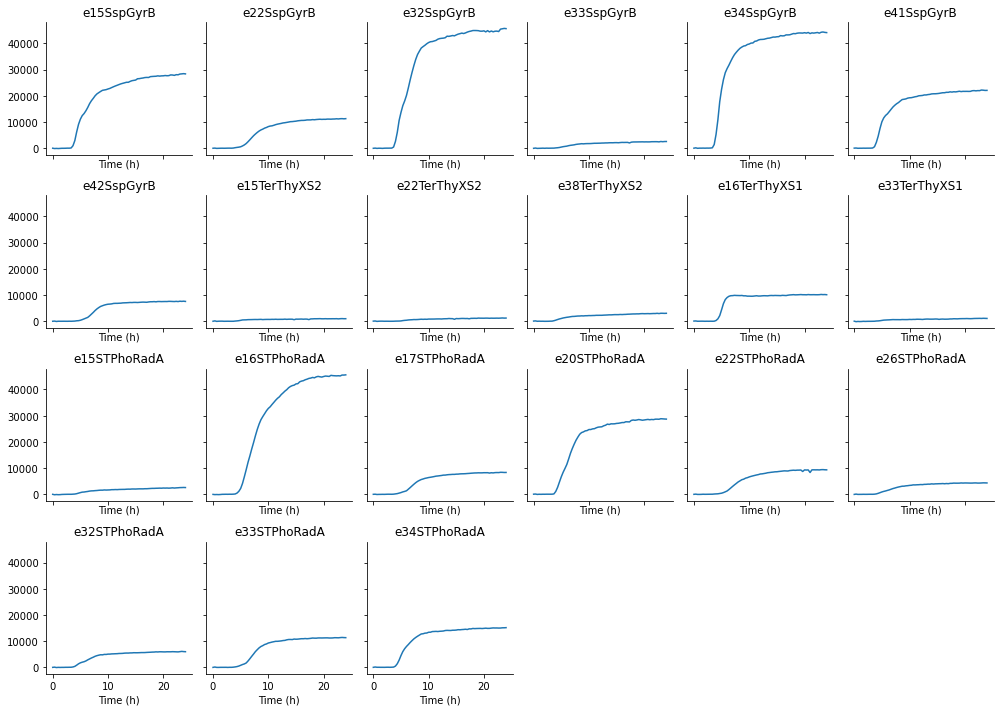

In [3]:
def plot_all(data, num_row, num_col):
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2.5))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < num_traces:
            ax.plot(data.index / 60, data.iloc[:, i])
            ax.set_title(data.columns[i])
            #plt.xticks(rotation=90)
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot bulk fluorescence data
plot_all(fluo, 4, 6)

In [4]:
#od only data
od = pd.read_csv('datasets/od-11.csv', index_col=0)
od.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,e16TerThyXS1,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
time,,,,,,,,,,,,,,,,,,,,,
0,0.025,0.026,0.040,0.032,0.024,0.0210,0.0300,0.010,0.015,-0.001,-0.005,0.002,0.007,0.021,0.020,0.0100,0.0200,0.021,0.0250,0.024,0.016
20,0.018,0.004,0.004,0.001,-0.006,-0.0004,-0.0002,-0.007,-0.004,-0.005,-0.008,0.018,0.021,0.017,0.003,-0.0004,0.0003,-0.002,-0.0001,-0.007,-0.008
40,0.019,0.016,0.017,0.014,0.010,0.0120,0.0130,0.007,0.011,0.008,0.004,0.013,0.018,0.017,0.014,0.0110,0.0130,0.010,0.0160,0.006,0.002
60,0.031,0.015,0.012,0.011,0.007,0.0100,0.0070,0.003,0.005,0.009,0.003,0.023,0.033,0.029,0.015,0.0110,0.0150,0.010,0.0130,0.007,0.002
80,0.037,0.020,0.021,0.016,0.011,0.0170,0.0140,0.005,0.007,0.018,0.005,0.022,0.037,0.033,0.022,0.0170,0.0260,0.016,0.0210,0.012,0.005


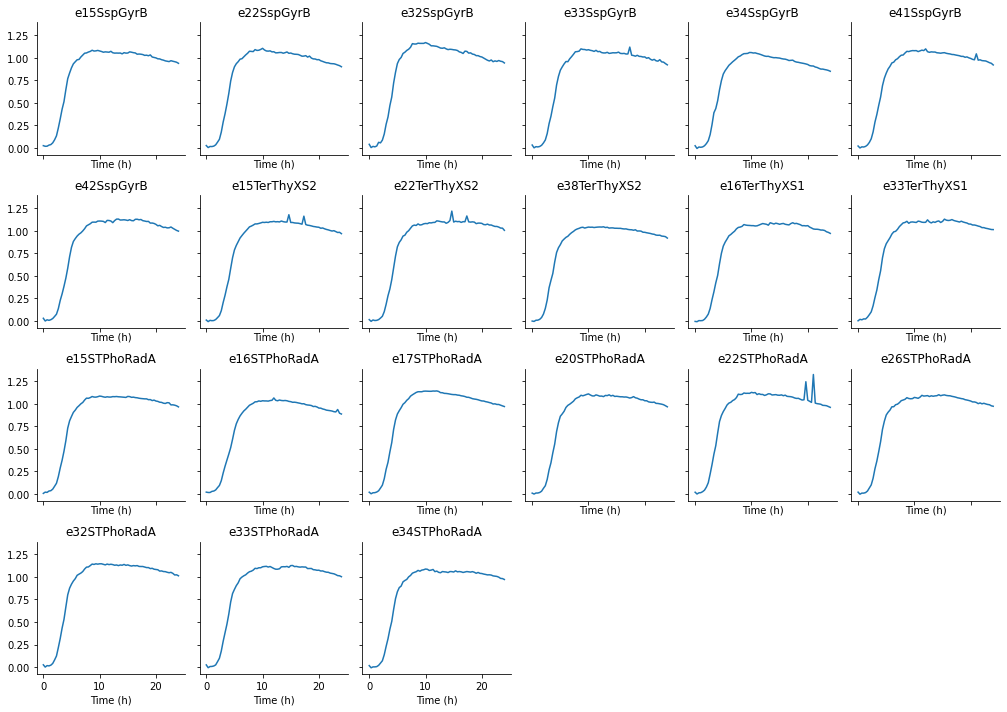

In [5]:
plot_all(od, 4, 6)

## Modeling OD

Changes:
- Also fitting the initial density $c_0$. Without this, the shape isn't quite right.
- Using the real time values, instead of np.arange

In [6]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

### Functions for 1st level inference (fitting growth data) ###
def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

In [7]:
od_bounds = [(0, 0, 0), (1, 2, 0.1)]
od_params = []
od_t = od.index
for idx in range(num_traces):
    od_data = od[od.columns[idx]]
    opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
    od_params.append(opt)

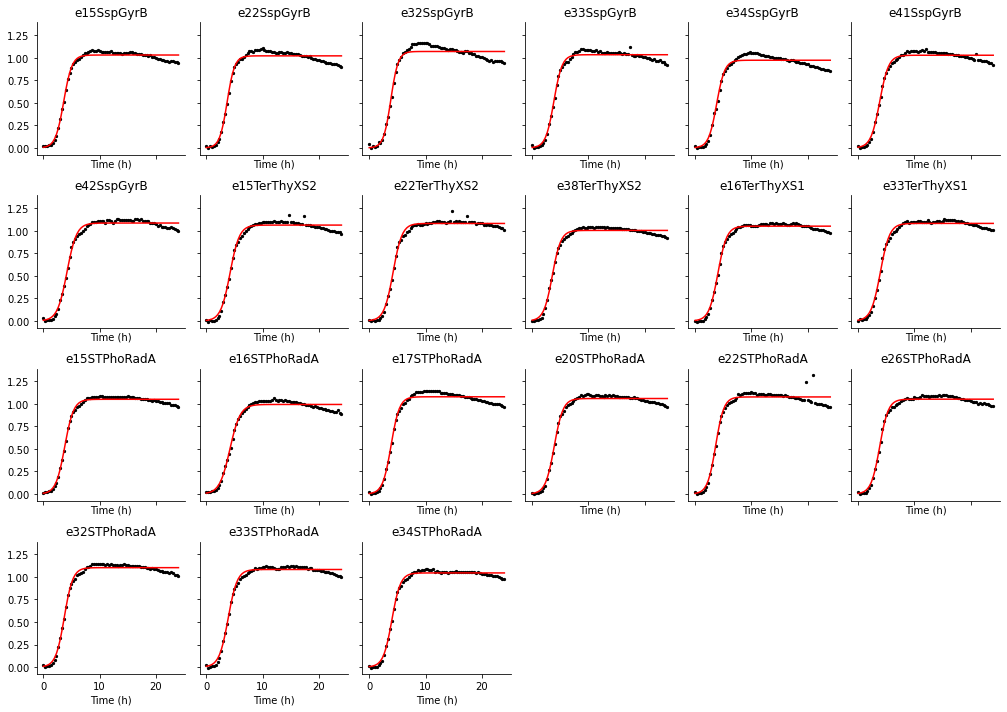

In [8]:
num_col = 6
num_row = 4
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2.5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        r, K, c0 = od_params[i]
        ax.scatter(od_t / 60, od.iloc[:, i], c='k', s=5)
        ax.plot(od_t / 60, od_wrapper(od_t, r, K, c0), c='r')
        ax.set_title(od.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

## Modelling fluorescence

In [25]:
def hill_equation(x, n):
    return x**n / (1 + x**n)

def gate_wrapper_treat(t, deg_ECFn, deg_ECFc, deg_ECF, syn_ECF, syn_GFP, deg_GFP, n, treat, extra, y0):

    def gate_model(y, t):
    
        induce = 1.0 if t>=treat else 0.0
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        #fixed parameters
        mgr, mcc = extra
        gamma = growth_rate(t, OD, mgr, mcc)
        
        #differential equations
        dOD = gamma * OD
        dECFn = induce - (deg_ECFn + gamma) * ECFn
        dECFc = induce - (deg_ECFc + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg_ECF * ECF)
        dGFP = syn_GFP * hill_equation(ECF, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def gate_wrapper(t, deg_ECFn, deg_ECF, syn_ECF, syn_GFP, deg_GFP, n, extra, y0):

    def gate_model(y, t):
    
        #dependent variables
        ECFn, ECF, GFP, OD = y
        #fixed parameters
        mgr, mcc = extra
        gamma = growth_rate(t, OD, mgr, mcc)
        
        #differential equations
        dOD = gamma * OD
        dECFn = 1 - (deg_ECFn + gamma) * ECFn
        dECF = syn_ECF * ECFn * ECFn - (deg_ECF * ECF)
        dGFP = syn_GFP * hill_equation(ECF, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

Test model wrapper

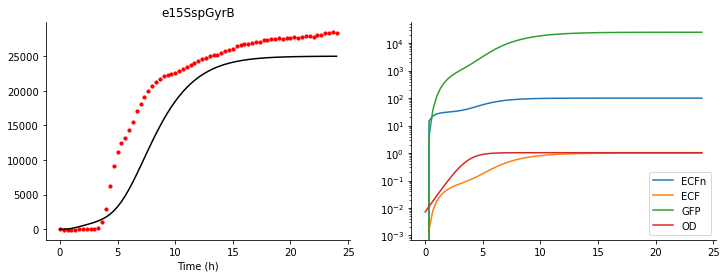

In [68]:
f_t = fluo.index
idx = 0
r, K, c0 = od_params[idx]
extra = r, K
y0 = [0, 0, 0, c0]
f_sim = gate_wrapper(f_t, 1e-2, 1e-2, 1e-6, 5e2, 1e-2, 1, extra, y0)

title = fluo.columns[0]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax = axs[0]
ax.scatter(f_t / 60, fluo[title], c='r', s=10)
ax.plot(f_t / 60, f_sim[2], c='k')
ax.set_xlabel('Time (h)')
ax.set_title(title)

ax = axs[1]
for y, label in zip(f_sim, ['ECFn', 'ECF', 'GFP', 'OD']):
    ax.semilogy(f_t / 60, y, label = label)
ax.legend()
sns.despine()

### Define inference helper functions

In [50]:
def compare_model_data(f_t, f_data, f_sim, ax):
    ax.scatter(f_t / 60, f_data, c='r', s=10)
    ax.plot(f_t / 60, f_sim, c='k')
    ax.set_xlabel('Time (h)')

### Fit all parameters separately - but fix $n$
Start with an example

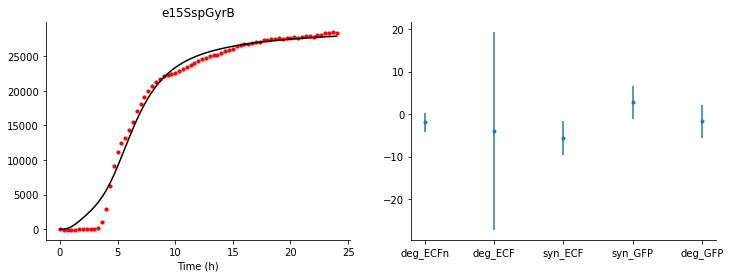

In [94]:
idx = 0
f_t = fluo.index
#gate_bounds_scaled = [[-4, -4, -8, 0, -4, 0.5], [0, 0, 0, 5, 0, 2]]
gate_bounds_scaled = [[-4, -4, -8, 0, -4], [0, 0, -4, 5, 0]]

def fit_scaled(idx):
    #parameters = ['deg_ECFn', 'deg_ECF', 'syn_ECF', 'syn_GFP', 'deg_GFP', 'n']
    #init_guess = [-2, -2, -6, 3, -1, 1]
    parameters = ['deg_ECFn', 'deg_ECF', 'syn_ECF', 'syn_GFP', 'deg_GFP']
    init_guess = [-2, -2, -6, 3, -1]
    
    r, K, c0 = od_params[idx]
    extra = r, K
    y0 = [0, 0, 0, c0]

    def model_fit(t, a, b, c, d, e):
        fit = gate_wrapper(t, 10**a, 10**b, 10**c, 10**d, 10**e, 1, extra, y0)
        return fit[2] #* fit[4] #3 for GFP index

    f_t = fluo.index
    title = fluo.columns[idx]
    f_data = fluo[title]

    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_scaled, method='trf')
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data 

f_df, f_sim, f_data = fit_scaled(idx)

f, axs = plt.subplots(1, 2, figsize=(12,4))
compare_model_data(f_t, f_data, f_sim, axs[0])
axs[0].set_title(title)
axs[1].errorbar(f_df['Parameters'], f_df['Value'], f_df['Err'], fmt='.')

sns.despine()

Now fit all traces

In [95]:
f_df_scaled, f_sim_scaled, f_data_scaled = zip(*[fit_scaled(idx) for idx in tqdm.trange(len(od_params))])


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:34<00:00,  4.50s/it]


Plot the parameter values

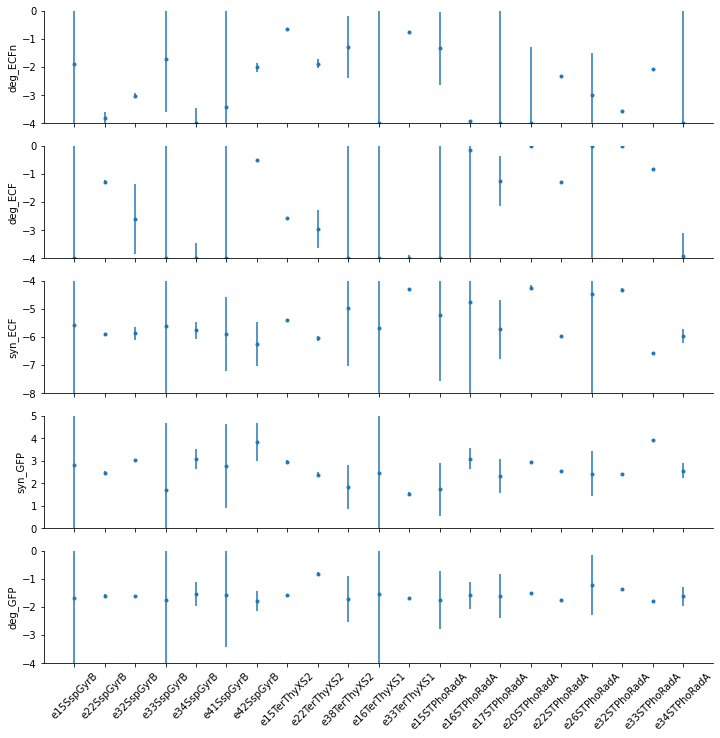

In [96]:
def plot_parameters(f_df, bounds):
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(12,2*(n_paras+1)))
    for i, ax in enumerate(axs):
        ax.errorbar(fluo.columns, values[:,i], errors[:,i], fmt='.')
        ax.set_ylim(bounds[0][i], bounds[1][i])
        ax.set_ylabel(parameters[i])
    plt.xticks(rotation=45);
    sns.despine()
    
plot_parameters(f_df_scaled, gate_bounds_scaled)

Plot model-data comparison

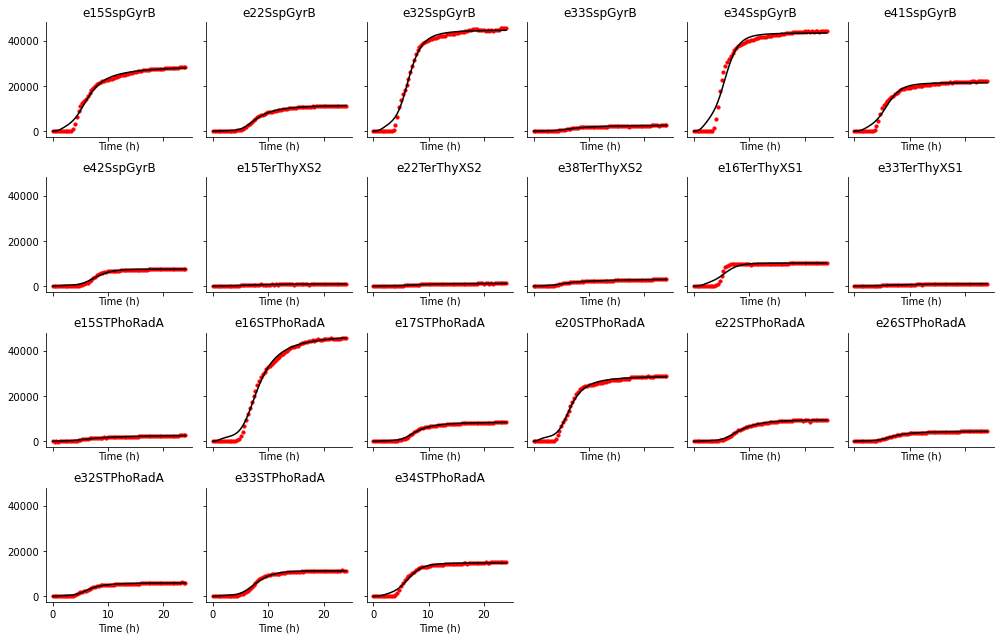

In [97]:
def plot_comparisons(f_sim, f_data):
    fig, axs = plt.subplots(4, 6, sharex=True, sharey=True, figsize=(14, 9))
    axr = axs.ravel()

    for i, ax in enumerate(axr):
        if i < num_traces:
            ax = axr[i]
            compare_model_data(f_t, f_data[i], f_sim[i], ax)
            ax.set_title(fluo.columns[i])
        else:
            ax.set_visible(False)
    plt.tight_layout()

    sns.despine()
    
plot_comparisons(f_sim_scaled, f_data_scaled)

### Fit all parameters separately - vary $n$
Start with an example

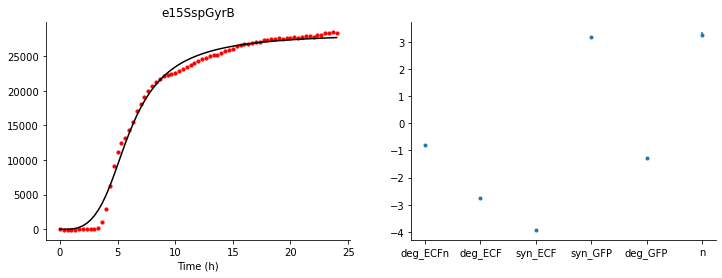

In [109]:
idx = 0
f_t = fluo.index
gate_bounds_scaled_2 = [[-4, -4, -8, 0, -4, 0.5], [0, 0, 0, 5, 0, 4]]

def fit_scaled_2(idx):
    parameters = ['deg_ECFn', 'deg_ECF', 'syn_ECF', 'syn_GFP', 'deg_GFP', 'n']
    init_guess = [-2, -2, -6, 3, -1, 1]
    
    r, K, c0 = od_params[idx]
    extra = r, K
    y0 = [0, 0, 0, c0]

    def model_fit(t, a, b, c, d, e, f):
        fit = gate_wrapper(t, 10**a, 10**b, 10**c, 10**d, 10**e, f, extra, y0)
        return fit[2] #* fit[4] #3 for GFP index

    f_t = fluo.index
    title = fluo.columns[idx]
    f_data = fluo[title]

    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_scaled_2, method='trf')
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data 

f_df, f_sim, f_data = fit_scaled_2(idx)

f, axs = plt.subplots(1, 2, figsize=(12,4))
compare_model_data(f_t, f_data, f_sim, axs[0])
axs[0].set_title(title)
axs[1].errorbar(f_df['Parameters'], f_df['Value'], f_df['Err'], fmt='.')

sns.despine()

Now fit all traces

In [112]:
f_df_scaled_2, f_sim_scaled_2, f_data_scaled_2 = zip(*[fit_scaled_2(idx) for idx in tqdm.trange(len(od_params))])


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:40<00:00,  1.91s/it]


#### Plot model-data comparison
A definite improvement by allowing $n$ to vary, but high values are almost always selected. Do we really have such a strong sensitivity to intracellular ECF abundance? 

 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [28:05<02:57, 88.69s/it]


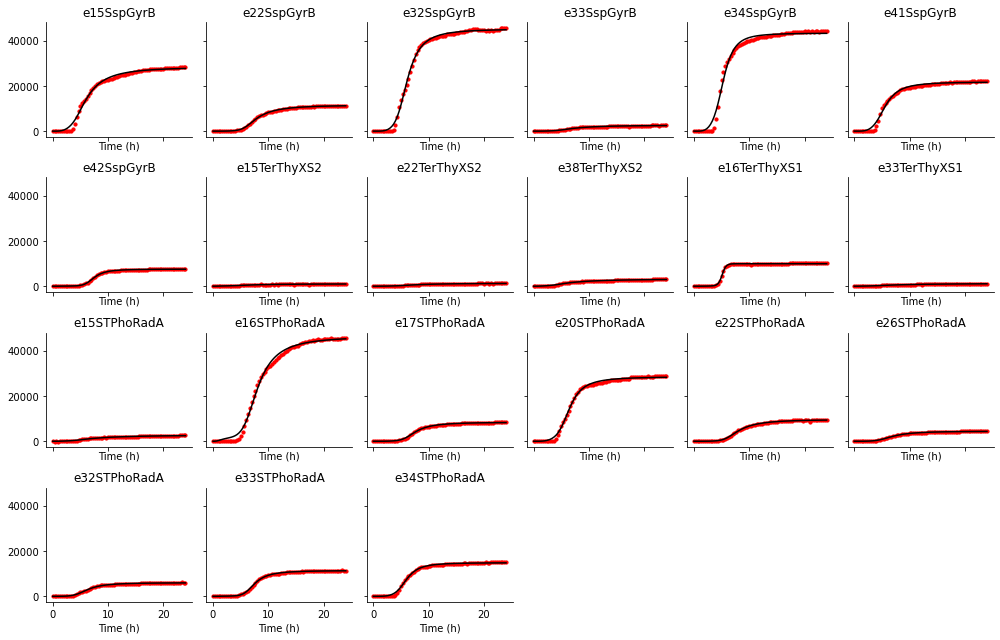

In [114]:
plot_comparisons(f_sim_scaled_2, f_data_scaled_2)

#### Plot the parameter values
Despite a great fit to the data, the parameter inference contains considerable uncertainty

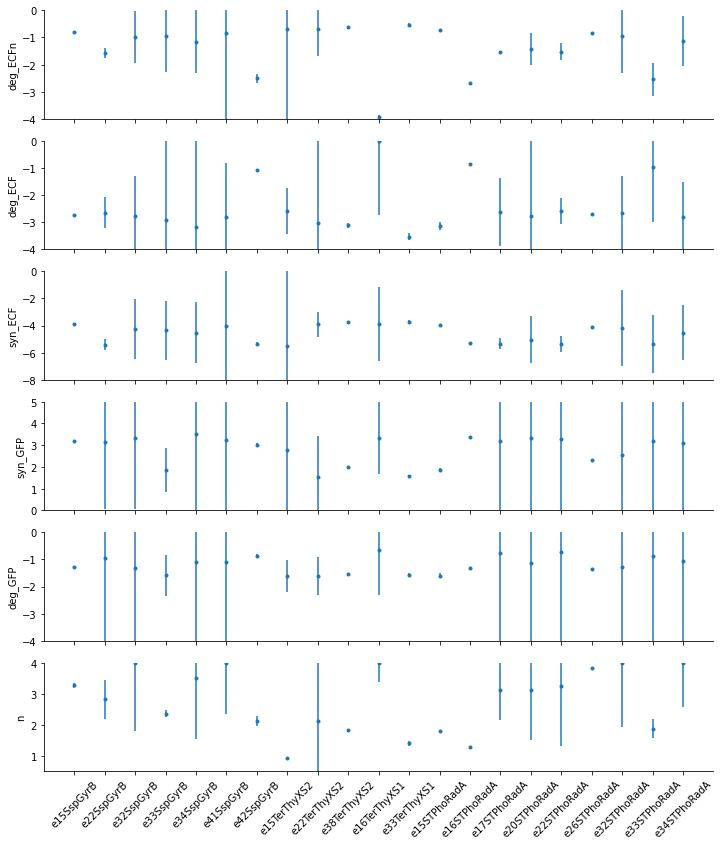

In [113]:
plot_parameters(f_df_scaled_2, gate_bounds_scaled_2)

### Fit degradation parameters together
The goal here is to reduce parameter uncertainty by assuming that the degradation of each protein (ECF_n, ECF_c, ECF and GFP) occurs at the same rate.

#### Example

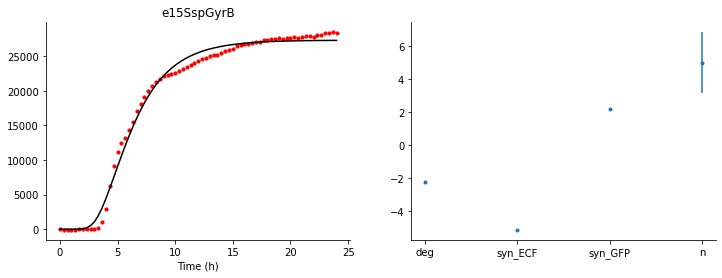

In [121]:
idx = 0
f_t = fluo.index
gate_bounds_together = [[-4, -10, 0, 0.5], [0, -4, 5, 5]]
    
def fit_deg_together(idx):
    parameters = ['deg', 'syn_ECF', 'syn_GFP', 'n']
    init_guess = [-2, -6, 3, 1]
    
    r, K, c0 = od_params[idx]
    extra = r, K
    y0 = [0, 0, 0, c0]

    def model_fit(t, a, b, c, d):
        fit = gate_wrapper(t, 10**a, 10**a, 10**b, 10**c, 10**a, d, extra, y0)
        return fit[2] #* fit[4] #3 for GFP index

    f_t = fluo.index
    title = fluo.columns[idx]
    f_data = fluo[title]

    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together, method='dogbox')
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data 

f_df, f_sim, f_data = fit_deg_together(idx)

f, axs = plt.subplots(1, 2, figsize=(12,4))
compare_model_data(f_t, f_data, f_sim, axs[0])
axs[0].set_title(title)
axs[1].errorbar(f_df['Parameters'], f_df['Value'], f_df['Err'], fmt='.')

sns.despine()

#### Fit parameters

In [122]:
f_df_deg, f_sim_deg, f_data_deg = zip(*[fit_deg_together(idx) for idx in tqdm.trange(len(od_params))])

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]


#### Plot model-data comparison
No noticeable loss in performance of the model-data comparison.

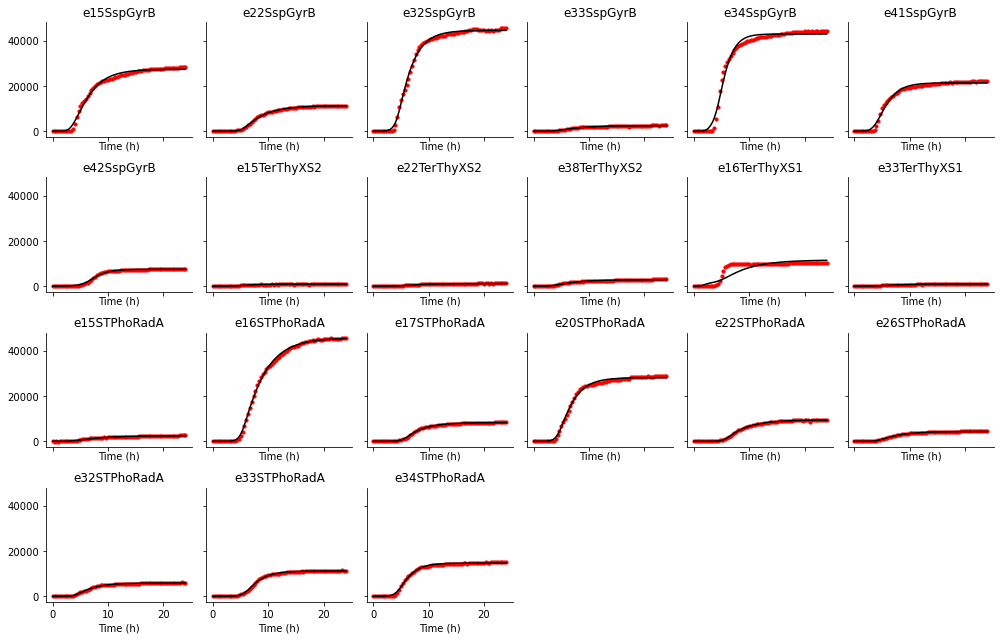

In [123]:
plot_comparisons(f_sim_deg, f_data_deg)

#### Plot the parameter values
Now we see much reduced uncertainty on parameter estimates. 
- Only minor variations in deg and syn_ECF are observed. 
- Inter-sample variation most pronounced in syn_GFP.
- High uncertainty in n, and estimates at the upper bound of 5, which seems especially unrealistic.

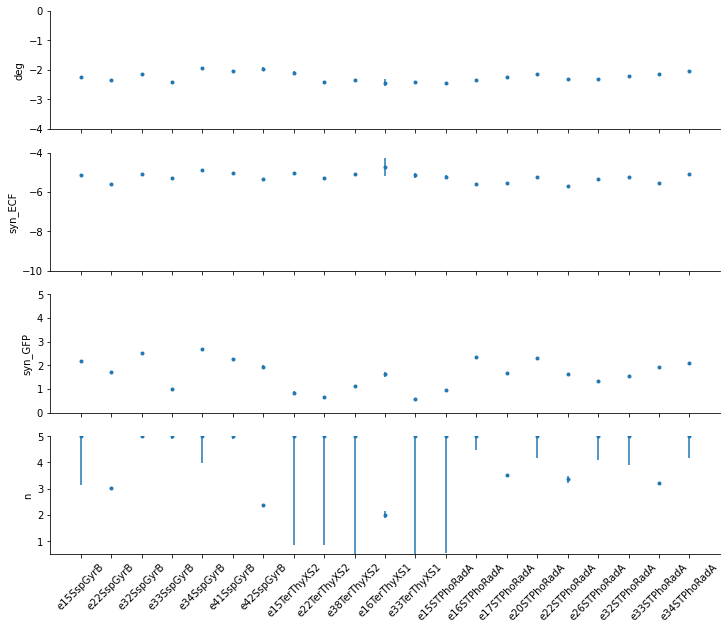

In [124]:
plot_parameters(f_df_deg, gate_bounds_together)